In [1]:
# calculate residual errors for a persistence forecast model
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

import pickle, time, os, sys, re, random

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot

from statsmodels.distributions.copula.api import CopulaDistribution, StudentTCopula
try:
    from scipy import stats
except:
    pip install scipy -U
    from scipy import stats
    
import numpy as np
from tqdm import tqdm
from collections import OrderedDict

In [2]:
import statsmodels
statsmodels.__version__

'0.14.0'

In [3]:
q_r = pd.read_csv("Quarterly Return.csv")

In [4]:
print(q_r.shape)
q_r.head()

(389, 6)


,Month_year,Stock-Total,Dividend,Bond-Total,Bond-Income,Inflation
0,3/31/1926,-0.093723,0.008723,0.024368,0.009221,-0.005587
1,6/30/1926,0.091397,0.015456,0.012858,0.009135,-0.005618
2,9/30/1926,0.100978,0.012531,0.004205,0.009296,-0.011299
3,12/31/1926,0.025025,0.018409,0.034352,0.009143,0.011429
4,3/31/1927,0.042398,0.009731,0.042056,0.008612,-0.022599


In [5]:
q_r.iloc[:,range(1, 6)].mean(axis = 0)

Stock-Total    0.030007
Dividend       0.009456
Bond-Total     0.013857
Bond-Income    0.012283
Inflation      0.007371
dtype: float64

In [6]:
rmd = pd.read_csv("rmd_quarter.csv")

Text(0.5, 1.0, 'Dividend w/ Difference(1)')

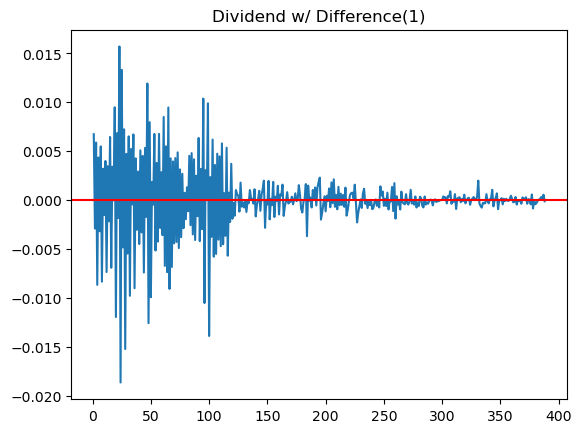

In [7]:
plt.plot(q_r['Dividend'].diff().dropna())
plt.axhline(y = 0, color = "r")
plt.title("Dividend w/ Difference(1)")

Text(0.5, 1.0, 'Bond Income w/ Difference(1)')

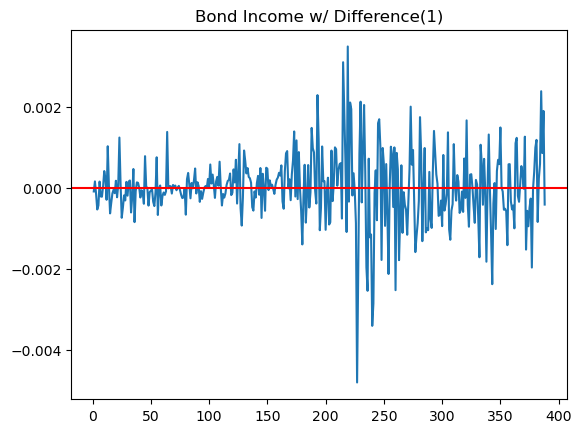

In [8]:
plt.plot(q_r['Bond-Income'].diff().dropna())
plt.axhline(y = 0, color = "r")
plt.title("Bond Income w/ Difference(1)")

In [9]:
div_ret = 100 * q_r['Dividend'].pct_change().dropna()

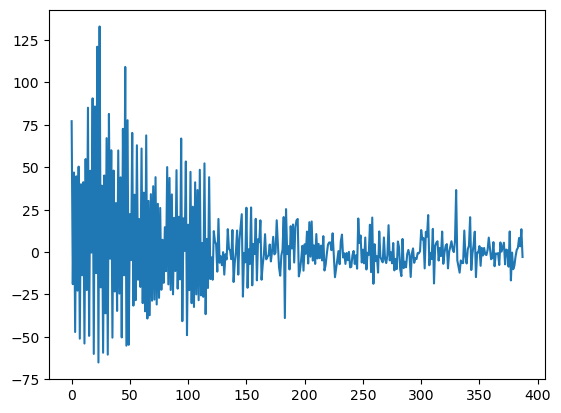

In [10]:
plt.plot(list(div_ret))

# get subset of q_r after 1972

In [11]:
q_r['Month_year'] = pd.to_datetime(q_r.Month_year)

In [12]:
q_r_sub = q_r[q_r.Month_year >= "1971-12-31"]
q_r_sub.head()

,Month_year,Stock-Total,Dividend,Bond-Total,Bond-Income,Inflation
183,1971-12-31,0.046433,0.009519,0.016406,0.014863,0.007353
184,1972-03-31,0.057512,0.005815,-0.005801,0.014660,0.007299
185,1972-06-30,0.006667,0.007288,0.023170,0.015224,0.007246
186,1972-09-30,0.039185,0.007205,0.016006,0.014743,0.009592
187,1972-12-31,0.075637,0.007461,0.022586,0.014639,0.009501


In [13]:
q_r_sub.shape

(206, 6)

In [14]:
q_r_sub[['Stock-Total','Dividend','Bond-Total','Bond-Income','Inflation']].mean(axis = 0)

Stock-Total    0.029029
Dividend       0.007217
Bond-Total     0.019288
Bond-Income    0.015783
Inflation      0.009811
dtype: float64

# stationarity test

In [15]:
def adf_test(series):
    #print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    #dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    # for key,value in dftest[4].items():
    #     dfoutput['Critical Value (%s)'%key] = value
    if dftest[1] >0.05:
        print (f"{series.name} is not stationary")
    else:
        print (f"{series.name} is stationary")

In [16]:
q_r.columns[1]

'Stock-Total'

In [17]:
for i in q_r.columns[1:]:
    adf_test(q_r_sub.loc[:,i])

Stock-Total is stationary
Dividend is not stationary
Bond-Total is stationary
Bond-Income is not stationary
Inflation is not stationary


# autoregression test

In [18]:
from statsmodels.stats.stattools import durbin_watson

In [19]:
for i in q_r_sub.columns[1:]:
    ''' check is the DW test return a value between 1.5 and 2.5'''
    
    print(i ,  durbin_watson(q_r_sub.loc[:,i]))

Stock-Total 1.6924584032578667
Dividend 0.008831889603359028
Bond-Total 1.869730439943229
Bond-Income 0.004130971725187002
Inflation 0.6043385400510163


# TEST: fit yt vs yt-1

In [18]:
q_r_sub.columns

Index(['Month_year', 'Stock-Total', 'Dividend', 'Bond-Total', 'Bond-Income',
       'Inflation'],
      dtype='object')

In [19]:
for i in ['Dividend','Bond-Income', 'Inflation']:
    q_r_sub[f"{i}_lag"] = q_r_sub[i].shift()

In [20]:
q_r_sub.dropna(inplace = True)
q_r_sub.head()

,Month_year,Stock-Total,Dividend,Bond-Total,Bond-Income,Inflation,Dividend_lag,Bond-Income_lag,Inflation_lag
184,1972-03-31,0.057512,0.005815,-0.005801,0.014660,0.007299,0.009519,0.014863,0.007353
185,1972-06-30,0.006667,0.007288,0.023170,0.015224,0.007246,0.005815,0.014660,0.007299
186,1972-09-30,0.039185,0.007205,0.016006,0.014743,0.009592,0.007288,0.015224,0.007246
187,1972-12-31,0.075637,0.007461,0.022586,0.014639,0.009501,0.007205,0.014743,0.009592
188,1973-03-31,-0.048867,0.006697,-0.022802,0.016119,0.018824,0.007461,0.014639,0.009501


In [21]:
q_r_sub.shape

(205, 9)

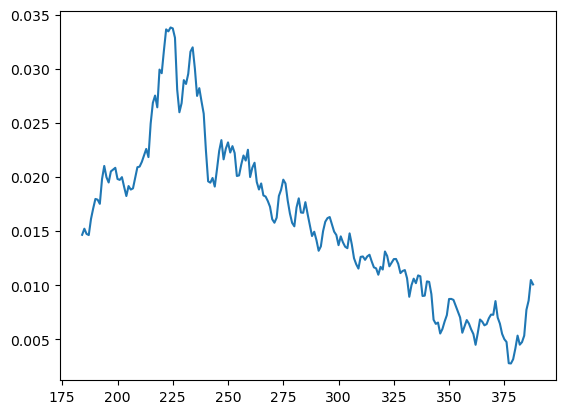

In [22]:
plt.plot(q_r_sub['Bond-Income'])

In [23]:
pickle.dump(q_r_sub, open("q_r_sub.pkl", "wb"))

In [18]:
q_r_sub = pickle.load(open("q_r_sub.pkl", "rb"))

In [19]:
q_r_sub.iloc[:,[1,2,3,4,5]].mean(axis=0)

Stock-Total    0.028944
Dividend       0.007206
Bond-Total     0.019302
Bond-Income    0.015788
Inflation      0.009823
dtype: float64

In [108]:
#get correlation coeff of 5 rates
q_r_sub.iloc[:,[1,2,3,4,5]].corr()

,Stock-Total,Dividend,Bond-Total,Bond-Income,Inflation
Stock-Total,1.000000,0.056130,-0.015046,0.012677,-0.091492
Dividend,0.056130,1.000000,0.105369,0.803612,0.430450
Bond-Total,-0.015046,0.105369,1.000000,0.142240,-0.285010
Bond-Income,0.012677,0.803612,0.142240,1.000000,0.346519
Inflation,-0.091492,0.430450,-0.285010,0.346519,1.000000


# fit individual Student t-distribution

In [145]:
stats.t.fit(q_r_sub['Stock-Total']) #df, mu, sigma

(5.286461935108223, 0.03457968887136153, 0.06660030584433152)

In [259]:
stats.t.fit(q_r_sub['Stock-Total'], floc= q_r_sub['Stock-Total'].mean()) #df, mu, sigma

(6.070730536329348, 0.02894407027317073, 0.06853539039179579)

# simulate non-negative dividend 

In [146]:
div_log = np.log(q_r_sub.Dividend)
div_lag_log = np.log(q_r_sub.Dividend_lag)

In [147]:
dividend_fit = LinearRegression().fit(pd.DataFrame(div_lag_log), div_log)
print(f"intercept: {dividend_fit.intercept_}; coef_: {dividend_fit.coef_}")

intercept: -0.11631923080675044; coef_: [0.97758717]


In [148]:
dividend_error = div_log - dividend_fit.predict(pd.DataFrame(div_lag_log))

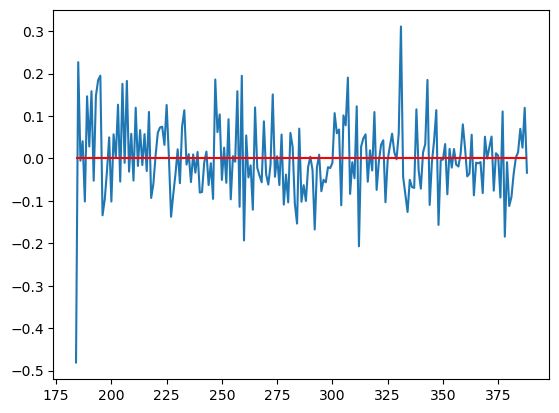

In [149]:
plt.plot(dividend_error)
plt.hlines(y = 0, xmin = dividend_error.index.min(), xmax = dividend_error.index.max(),
           color = "red")

# fit bond income distribution

In [150]:
q_r_sub.columns

Index(['Month_year', 'Stock-Total', 'Dividend', 'Bond-Total', 'Bond-Income',
       'Inflation', 'Dividend_lag', 'Bond-Income_lag', 'Inflation_lag'],
      dtype='object')

In [151]:
income_log = np.log(q_r_sub['Bond-Income'])
income_lag_log = np.log(q_r_sub['Bond-Income_lag'])

In [152]:
income_fit = LinearRegression().fit(pd.DataFrame(income_lag_log), income_log)
print(f"intercept: {income_fit.intercept_}; coef_: {income_fit.coef_}")

intercept: -0.06333900149697413; coef_: [0.98562594]


In [153]:
income_error = income_log - income_fit.predict(pd.DataFrame(income_lag_log))

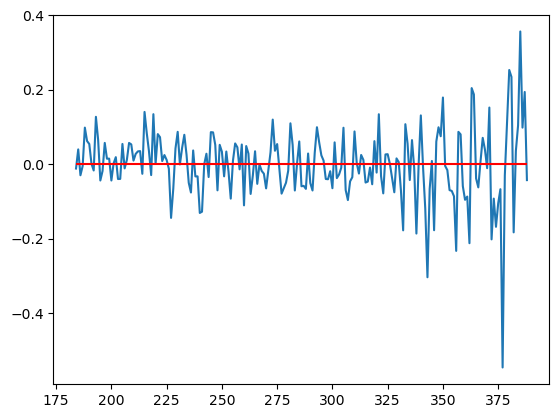

In [154]:
plt.plot(income_error)
plt.hlines(y = 0, xmin = income_error.index.min(), xmax = income_error.index.max(),
           color = "red")

# fit inflation distribution

In [155]:
q_r_sub.columns

Index(['Month_year', 'Stock-Total', 'Dividend', 'Bond-Total', 'Bond-Income',
       'Inflation', 'Dividend_lag', 'Bond-Income_lag', 'Inflation_lag'],
      dtype='object')

In [156]:
inflation_fit = LinearRegression().fit(q_r_sub[['Inflation_lag']], q_r_sub.Inflation)
print(f"intercept: {inflation_fit.intercept_}; coef_: {inflation_fit.coef_}")

intercept: 0.0058517883224974586; coef_: [0.40624012]


In [157]:
inflation_error = q_r_sub.Inflation - inflation_fit.predict(q_r_sub[['Inflation_lag']])

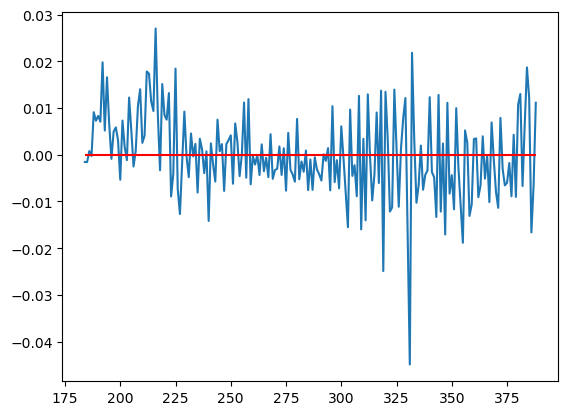

In [158]:
plt.plot(inflation_error)
plt.hlines(y = 0, xmin = inflation_error.index.min(), xmax = inflation_error.index.max(),
           color = "red")

In [159]:
pickle.dump((income_fit, dividend_fit, inflation_fit), open("fits.pkl", "wb"))

In [20]:
(income_fit, dividend_fit, inflation_fit) = pickle.load(open("fits.pkl", "rb"))

# simulate Dividend and Bond_Income errors

In [40]:
pickle.dump((income_error, dividend_error, inflation_error), open("errors.pkl", "wb"))

In [21]:
(income_error, dividend_error, inflation_error) = pickle.load(open("errors.pkl", "rb"))

In [29]:
q_r_sub.tail()

,Month_year,Stock-Total,Dividend,Bond-Total,Bond-Income,Inflation
384,2022-03-31,-0.045985,0.003618,-0.089716,0.005343,0.031212
385,2022-06-30,-0.161011,0.003917,-0.103663,0.007727,0.030633
386,2022-09-30,-0.048826,0.004049,-0.091893,0.008586,0.001677
387,2022-12-31,0.075610,0.004595,-0.002332,0.010484,-0.000037
388,2023-03-31,0.074971,0.004462,0.055545,0.010075,0.016978


# fit t-distribution of 5 rates

In [22]:
error_df = pd.concat([q_r_sub['Stock-Total'], pd.Series(income_error), 
                      pd.Series(dividend_error), pd.Series(inflation_error),
                      q_r_sub['Bond-Total']], axis = 1)                      

In [27]:
error_df.shape

(206, 5)

In [204]:
q_r_sub['Stock-Total'].mean()

0.02894407027317073

In [208]:
stock_para = stats.t.fit(q_r_sub['Stock-Total'], floc= q_r_sub['Stock-Total'].mean())
income_para = stats.t.fit(income_error)
dividend_para = stats.t.fit(dividend_error)
inflation_para = stats.t.fit(inflation_error)
bond_para = stats.t.fit(q_r_sub['Bond-Total'], floc= q_r_sub['Bond-Total'].mean())

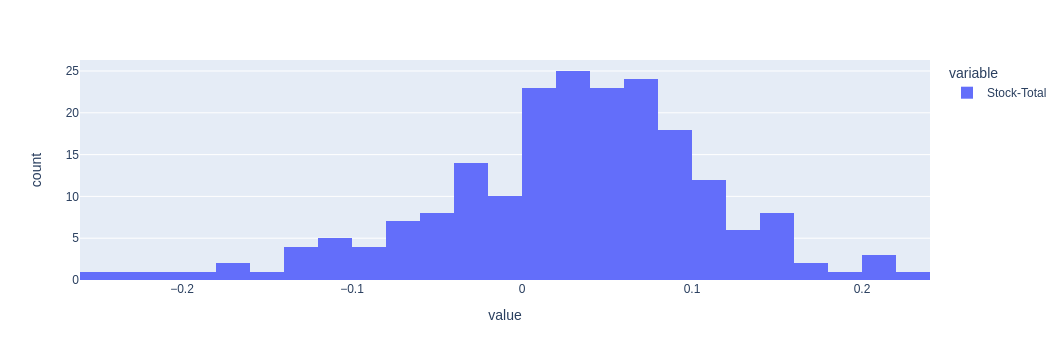

In [271]:
q_r_sub['Stock-Total'].hist(bins = 200)

In [262]:
stats.t.fit(q_r_sub['Stock-Total'], floc= q_r_sub['Stock-Total'].mean())

(6.070730536329348, 0.02894407027317073, 0.06853539039179579)

In [267]:
t_spl = stats.t.rvs(6.070730536329348, 0.02894407027317073, 0.06853539039179579, size = 10000)

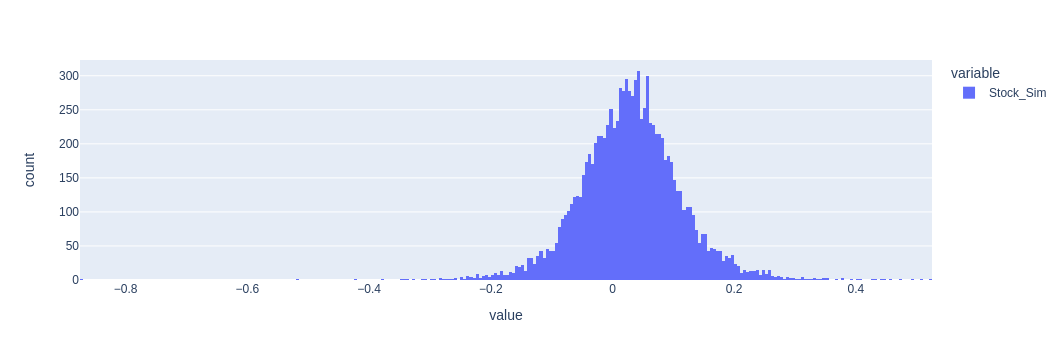

In [268]:
pd.Series(t_spl, name = "Stock_Sim").hist()

In [15]:
# for i in [stock_para, income_para, dividend_para, inflation_para, bond_para]:
#     print(i)

In [114]:
#degree of freedom for StudentTCopula()
df = np.mean([stock_para[0], income_para[0], dividend_para[0], inflation_para[0], bond_para[0]])
df

5.829194340544427

# create list of marginal distribution parameters for StudentTCopula

In [23]:
marginal_lst = [stats.t(6.070730536329348, 0.02894407027317073, 0.06853539039179579),
                stats.t(3.6292200056363453, 0.0014904997502419642, 0.06336038874846509),
                stats.t(6.119519041575349, -0.0022567952568445437, 0.07478635960824295),
                stats.t(9.455323049632403, -1.0307230734858667e-05, 0.008063621436368481),
                stats.t(4.961248837988938, 0.01930228812195122, 0.047629056593244394)]      

# optimized df of StudentTCopula

In [211]:
dfs = [stock_para[0], income_para[0], dividend_para[0], inflation_para[0], bond_para[0]]

In [212]:
df_min = round(min(dfs), 2); df_max = round(max(dfs), 2)
print(df_min, df_max)

3.63 9.46


In [30]:
error_df.shape

(206, 5)

In [214]:
corr_ = np.array(error_df.corr())
corr_

array([[ 1.        , -0.19203276, -0.24678987, -0.07884368, -0.0150461 ],
       [-0.19203276,  1.        ,  0.04031975,  0.21297988, -0.29162792],
       [-0.24678987,  0.04031975,  1.        , -0.23975582,  0.16883449],
       [-0.07884368,  0.21297988, -0.23975582,  1.        , -0.32884067],
       [-0.0150461 , -0.29162792,  0.16883449, -0.32884067,  1.        ]])

In [215]:
corr_abs_diff = {}
for i in tqdm(np.arange(df_min, df_max, 0.2)):
    sc_i = StudentTCopula(corr = corr_, df = i, k_dim=5)
    joint_dist = CopulaDistribution(copula=sc_i, marginals= marginal_lst) 
    sc_spl_i = joint_dist.rvs(50000, random_state = 1234)
    corr_i = np.array(pd.DataFrame(sc_spl_i).corr())
    corr_abs_diff[i] = abs(corr_[np.triu(np.ones_like(corr_)) == 0] - \
                           corr_i[np.triu(np.ones_like(corr_)) == 0]).sum()             

100%|███████████████████████████████████████████| 30/30 [00:16<00:00,  1.82it/s]


In [216]:
df_min = min(corr_abs_diff, key = corr_abs_diff.get)
df_min

6.630000000000003

In [24]:
df_min = 6.63

In [25]:
sc = StudentTCopula(corr = np.array(error_df.corr()), df = df_min, k_dim=5)

In [26]:
joint_dist = CopulaDistribution(copula=sc, marginals= marginal_lst) 

# Compare correlation of simulated and LR errors 

In [27]:
def getSim(y, ar_model, error, type = "non_log"):
    '''get simulation data from the LR model'''    
 
    sim_init = y[y.index.max()]
    sim_out = ar_model.intercept_ + ar_model.coef_[0] * sim_init + error   

    if type == "log":
        sim_out = np.exp(sim_out)
        return sim_out
    else:
        return sim_out        

# test scenarios 2 and 6

In [29]:
#read quarterly RMD table
rmd_quarter = pd.read_csv("rmd_quarter.csv")

In [30]:
rmd_quarter.head()

,Age,RMA
0,64.00,2.87%
1,64.25,2.87%
2,64.50,2.87%
3,64.75,2.87%
4,65.00,2.95%


In [31]:
rmd_quarter["RMD"] = [float(i.replace("%", ""))/400 for i in rmd_quarter.RMA]
rmd_quarter.head()

,Age,RMA,RMD
0,64.00,2.87%,0.007175
1,64.25,2.87%,0.007175
2,64.50,2.87%,0.007175
3,64.75,2.87%,0.007175
4,65.00,2.95%,0.007375


In [32]:
#test 20% more on IRS RMD guidance
rmd_quarter['RMD1'] = rmd_quarter.RMD*1.2

In [33]:
rmd_quarter.head()

,Age,RMA,RMD,RMD1
0,64.00,2.87%,0.007175,0.00861
1,64.25,2.87%,0.007175,0.00861
2,64.50,2.87%,0.007175,0.00861
3,64.75,2.87%,0.007175,0.00861
4,65.00,2.95%,0.007375,0.00885


In [34]:
def method_2_quarterly(org_amt, rmd_quarter, start_age, end_age, stock_bond_sim_df, 
                       stock_weight, bond_weight, rmd1 = False):
    
    balance = [] 
    withdrawal = [] 
    org_left = org_amt

    rmd_sub = rmd_quarter.loc[(rmd_quarter.Age >= start_age) & (rmd_quarter.Age <= end_age)]
    rmd_sub.index = list(np.arange(start_age, end_age+0.1, 0.25))

    for i in np.arange(start_age, end_age+0.1, 0.25):
        
        if i == start_age:
            '''withdraw RMD/RMD1 % initial balance at the retirement moment''' 
            if rmd1 == True:
                withdrawal_ = org_left * (rmd_sub.RMD1[i] \
                           + stock_weight * stock_bond_sim_df.Dividend[i] \
                                 + bond_weight * stock_bond_sim_df.Income[i])
            else:
                withdrawal_ = org_left * (rmd_sub.RMD[i] \
                           + stock_weight * stock_bond_sim_df.Dividend[i] \
                                 + bond_weight * stock_bond_sim_df.Income[i])
            
            withdrawal.append(withdrawal_)
            
            org_left =  (org_left - withdrawal_)                   
            balance.append(org_left)              

        else:            
            '''for the following quarters, the left balance will grow with total bond and total stock 
            returns before next quarterly withdrawal'''            
            grow_left =  org_left * (1 + bond_weight * stock_bond_sim_df.Bond[i] \
                                   + stock_weight * stock_bond_sim_df.Stock[i])

            if rmd1 == True:
                withdrawal_ = grow_left * rmd_sub.RMD1[i] \
                          + org_left * (stock_weight * stock_bond_sim_df.Dividend[i] \
                                        + bond_weight * stock_bond_sim_df.Income[i])
            else:
                withdrawal_ = grow_left * rmd_sub.RMD[i] \
                          + org_left * (stock_weight * stock_bond_sim_df.Dividend[i] \
                                      + bond_weight * stock_bond_sim_df.Income[i])              
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ >= grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_)             

    return balance, withdrawal

In [36]:
def method_6_quarterly(org_amt, start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight, withdrawal_rate = 0.06):
    
    balance = [] 
    withdrawal = []
    org_left = org_amt

    for i in np.arange(start_age, end_age+0.1, 0.25):        
        if i == start_age:
            '''withdraw 6% initial balance at the retirement moment'''  
            withdrawal.append(org_left * withdrawal_rate)
            org_left =  org_left * (1-withdrawal_rate)  
            balance.append(org_left)

        elif i == start_age + 0.25:
            '''apply cumulated inflation rate on the 6% of the first year balance''' 

            grow_left =  org_left * (1 + bond_weight * (stock_bond_sim_df.Bond[i]) \
                                  + stock_weight * (stock_bond_sim_df.Stock[i]))                                      

            cum_inflation = stock_bond_sim_df.Inflation[i]             
            withdrawal_ = grow_left * withdrawal_rate * (1 + cum_inflation)     
            
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_) 
        else:            
            grow_left =  org_left * (1 + bond_weight * (stock_bond_sim_df.Bond[i]) \
                                  + stock_weight * (stock_bond_sim_df.Stock[i]))                                      

            cum_inflation = (1+ stock_bond_sim_df.Inflation[i]) * (1+cum_inflation) - 1
            
            withdrawal_ = grow_left * withdrawal_rate * (1 + cum_inflation)  
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_) 

    return balance, withdrawal

In [44]:
def sim_10K_quarterly(org_amt, withdrawal_rate, start_age, end_age, 
            output_balance_path, output_withdrawal_path, sim_out = False):
    
    global joint_dist, q_r_sub, rmd_quarter
    
    '''1) withdrawal_rate is only for method 6
       2) Two types of rmd are used only for method 2 and 3
    '''
    
    print(f'org_amt = {org_amt}; quarterly withdrawal rate = {withdrawal_rate}')
    print(f'Output pickle files are {output_balance_path} and {output_withdrawal_path}.\n')
    
    balance_2_0_1 = {}
    balance_2_0_1_1 = {}
    balance_6_0_1 = {}
    
    withdrawal_2_0_1 = {}
    withdrawal_2_0_1_1 = {}
    withdrawal_6_0_1 = {}    
    
    
    quarters = np.arange(start_age, end_age+0.1, 0.25)   
    
    #output sim_dict for quarterly to annual rates conversion  
    sim_dict = {}

    for i in tqdm(range(10000)):
        
        '''simulate 10K of 141 autocorrelated quarterly data start with the last observed autocorrelaton data point'''
        
        stock_bond_sim_df = pd.DataFrame(joint_dist.rvs(141, random_state = i))                
        stock_bond_sim_df.index = list(quarters)
        stock_bond_sim_df.columns = ['Stock', 'Income','Dividend','Inflation','Bond']
        stock_bond_sim_df['Income'] = getSim(np.log(q_r_sub['Bond-Income']), 
                                             income_fit, stock_bond_sim_df.Income, type = "log")
        
        stock_bond_sim_df['Dividend'] = getSim(np.log(q_r_sub.Dividend), 
                                             dividend_fit, stock_bond_sim_df.Dividend, type = "log")
        
        stock_bond_sim_df['Inflation'] = getSim(q_r_sub.Inflation, 
                                            inflation_fit, stock_bond_sim_df.Inflation, type = "non_log")
        
        sim_dict[i] = stock_bond_sim_df

        balance_2_0_1[i], withdrawal_2_0_1[i] = method_2_quarterly(org_amt,rmd_quarter,
                                        start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight)

        balance_2_0_1_1[i], withdrawal_2_0_1_1[i] = method_2_quarterly(org_amt,rmd_quarter,
                                        start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight, rmd1 = True)

        balance_6_0_1[i], withdrawal_6_0_1[i] = method_6_quarterly(org_amt,start_age, 
                                        end_age, stock_bond_sim_df, stock_weight, bond_weight, withdrawal_rate =withdrawal_rate)

        
    pickle.dump((balance_2_0_1, balance_2_0_1_1, balance_6_0_1),                   
                open(f"{output_balance_path}", "wb")) 
   
    pickle.dump((withdrawal_2_0_1, withdrawal_2_0_1_1, withdrawal_6_0_1),
            open(f"{output_withdrawal_path}", "wb")) 
    
    if sim_out == True:
        return sim_dict

In [42]:
# set original retirmetn account balance, fixed quaterly withdrawl rate, bond/stock investiment ratio 
org_amt = 255200
withdrawal_rate = 0.06/4

#for all-stock portfolio
bond_weight = 0
stock_weight = 1

#for 60/40 split portfolio
bond_weight = 0.6
stock_weight = 0.4

#for 70/30 split portfolio
bond_weight = 0.7
stock_weight = 0.3

In [45]:
#get 1 iteration outputs
sim_dict = sim_10K_quarterly(org_amt, 0.06/4, 65, 100, 
                "./balance_quarterly_6pct_stock.pkl", 
                "./withdrawal_quarterly_6pct_stock.pkl", sim_out = True)

org_amt = 255200; quarterly withdrawal rate = 0.015
Output pickle files are ./balance_quarterly_6pct_stock.pkl and ./withdrawal_quarterly_6pct_stock.pkl.



100%|█████████████████████████████████████| 10000/10000 [02:02<00:00, 81.33it/s]


In [88]:
#sim_dict[0].to_csv("rates.csv", index = False)
sim_dict[0].head()

,Stock,Income,Dividend,Inflation,Bond
65.00,0.032198,0.010136,0.004250,0.013351,0.004110
65.25,0.088223,0.011025,0.004089,0.008114,-0.004539
65.50,0.097910,0.009943,0.004677,0.011438,0.063596
65.75,-0.022595,0.010576,0.004527,0.013336,0.020161
66.00,0.135305,0.008644,0.003712,0.027028,0.035292


In [89]:
#pickle.dump(annual_ret, open("annual_ret.pkl", "wb"))
pickle.dump(sim_dict, open("sim_dict.pkl", "wb")) #optional

# Export and merge csv files

In [53]:
def merge_df_quarterly(input_path):
    
    '''1) output 60/40 and 70/30 investment portfolios
       2) merge balance and withdrawal side-by-side by age'''
    
    file_lst = os.listdir(input_path)
    file_lst.sort()
    file_lst = [i for i in file_lst if i != '.ipynb_checkpoints']
    print(len(file_lst))
    #assert len(file_lst) == 72, "The input files # is more than 72."
    #assert len(file_lst) == 12, "The # of csv files is more than 12"
    
    file_len = int(len(file_lst)/2)
    
    for i in range(file_len):
        bal_i = pd.read_csv(f'{input_path}/{file_lst[i]}')
        wdrl_i = pd.read_csv(f'{input_path}/{file_lst[i+file_len]}')
    
        out_i = pd.concat([bal_i, wdrl_i], axis = 1)
        out_i.columns = ["balance" + str(i) for i in np.arange(65, 100.1, 0.25)] + \
                        ["withdrawal" + str(i) for i in np.arange(65, 100.1, 0.25)]
        
        out_i_col = out_i.columns
        #out_i = out_i[[i for sub_i in [[out_i_col[i]] + [out_i_col[i+36]] for i in range(36)] for i in sub_i]]
        out_i.to_csv(f"{input_path}/method_{file_lst[i]}", index = False)  

In [ ]:
def export_csv_quarterly(input_bal_path, input_wdrl_path, output_csv_path):
    
    is_output_path = os.path.exists(output_csv_path)
    if not is_output_path:
        os.mkdir(output_csv_path)

    (bal_2_6_4, bal_2_7_3, bal_2_6_4_1, bal_2_7_3_1, bal_6_6_4, bal_6_7_3) \
             = pickle.load(open(f"{input_bal_path}", "rb"))
    
    (wdrl_2_6_4, wdrl_2_7_3, wdrl_2_6_4_1, wdrl_2_7_3_1, wdrl_6_6_4, wdrl_6_7_3) \
             = pickle.load(open(f"{input_wdrl_path}", "rb"))
        
    export_lst = ['bal_2_6_4', 'wdrl_2_6_4', 'bal_2_7_3', 'wdrl_2_7_3',
                  'bal_2_6_4_1', 'wdrl_2_6_4_1', 'bal_2_7_3_1', 'wdrl_2_7_3_1',
                  'bal_6_6_4', 'wdrl_6_6_4', 'bal_6_7_3', 'wdrl_6_7_3']
    
    for idx, _dict in enumerate((bal_2_6_4, wdrl_2_6_4, bal_2_7_3, wdrl_2_7_3,
                                 bal_2_6_4_1, wdrl_2_6_4_1, bal_2_7_3_1, wdrl_2_7_3_1,
                                 bal_6_6_4, wdrl_6_6_4,bal_6_7_3, wdrl_6_7_3)):        
        
        bal_i = pd.DataFrame.from_dict(_dict, orient = "index", columns = list(np.arange(65, 100.1, 0.25)))
        bal_i.to_csv(f"{output_csv_path}/{export_lst[idx]}.csv", index = False)  

In [47]:
def export_csv_quarterly_stock(input_bal_path, input_wdrl_path, output_csv_path):
    
    ''' all stock portfolio'''
    
    is_output_path = os.path.exists(output_csv_path)
    if not is_output_path:
        os.mkdir(output_csv_path)

    (bal_2_0_1, bal_2_0_1_1, bal_6_0_1) \
             = pickle.load(open(f"{input_bal_path}", "rb"))
    
    (wdrl_2_0_1, wdrl_2_0_1_1, wdrl_6_0_1) \
             = pickle.load(open(f"{input_wdrl_path}", "rb"))
        
    export_lst = ['bal_2_0_1', 'wdrl_2_0_1', 
                  'bal_2_0_1_1', 'wdrl_2_0_1_1',
                  'bal_6_0_1', 'wdrl_6_0_1']
    
    for idx, _dict in enumerate((bal_2_0_1, wdrl_2_0_1,
                                 bal_2_0_1_1, wdrl_2_0_1_1,
                                 bal_6_0_1, wdrl_6_0_1)):        
        
        bal_i = pd.DataFrame.from_dict(_dict, orient = "index", columns = list(np.arange(65, 100.1, 0.25)))
        bal_i.to_csv(f"{output_csv_path}/{export_lst[idx]}.csv", index = False) 

# run 10K simulations on General settings

In [92]:
org_amt = 255200
withdrawal_rate = 0.06/4
# bond_weight = 0.6
# stock_weight = 0.4

In [93]:
# %%time

# sim_dict = sim_10K_quarterly(org_amt, rmd, 0.06/4, 65, 100, 
#                 "./balance_quarterly_6.pkl", 
#                 "./withdrawal_quarterly_6.pkl")

In [94]:
#pickle.dump(sim_dict, open("sim_dict_fixed_mean.pkl", "wb"))

In [49]:
export_csv_quarterly_stock("./balance_quarterly_6pct_stock.pkl", "./withdrawal_quarterly_6pct_stock.pkl",
                     "./outputs_quarterly_6pct_stock/")

In [54]:
merge_df_quarterly("./outputs_quarterly_6pct_stock")

6


# Aggreate quarteryl rates to annual rats

In [232]:
#sim_dict = pickle.load(open("sim_dict_fixed_mean.pkl", "rb"))

In [55]:
def annualRate(df):
    
    rate = []
    for i in range(5):      
        rate_j = 1
        for j in list(df.iloc[:,i]):
            rate_j *= (1+j)
        
        rate.append(rate_j-1)
            
    return rate    

In [57]:
annual_ret = {}
for i in tqdm(range(len(sim_dict))):
    sim_i = sim_dict[i]    
    
    ret_i = {}
    for j in range(0, len(sim_i)-4, 4):
        ret_i[sim_i.index[j]] = annualRate(sim_i.iloc[j:(j+4)])
        
    annual_ret[i] = ret_i

In [62]:
#pickle.dump(annual_ret, open("annual_ret.pkl", "wb"))
pickle.dump(annual_ret, open("annual_ret_fix_mean.pkl", "wb"))

In [58]:
annual_ret = pickle.load(open("annual_ret_fix_mean.pkl", "rb"))

# covert quarter rate into annual rates

In [248]:
annual_rates = pd.DataFrame(columns = ['Sim', 'Stock', 'Income', 'Dividend', 'Inflation', 'Bond'])
for i in tqdm(list(annual_ret.keys())):
    df_i = pd.DataFrame(annual_ret[i]).T
    df_i.columns = ['Stock', 'Income', 'Dividend', 'Inflation', 'Bond']
    df_i["Sim"] = i
    annual_rates = pd.concat([annual_rates, df_i])

100%|████████████████████████████████████| 10000/10000 [00:39<00:00, 255.31it/s]


In [249]:
print(annual_rates.shape)
annual_rates.head()

(350000, 6)


,Sim,Stock,Income,Dividend,Inflation,Bond
65.0,0,0.205374,0.042336,0.017659,0.047039,0.084568
66.0,0,0.095912,0.039214,0.016924,0.056541,0.033769
67.0,0,0.094955,0.040528,0.017710,0.047015,0.149674
68.0,0,-0.036227,0.044169,0.018353,0.040775,0.248370
69.0,0,0.328871,0.041526,0.016763,0.065348,0.054918


In [252]:
annual_rates.iloc[:, 1:].mean(axis = 0)

Stock        0.120964
Income       0.041281
Dividend     0.018093
Inflation    0.051979
Bond         0.079473
dtype: float64

In [278]:
q_r_sub[['Stock-Total','Bond-Income','Dividend','Inflation','Bond-Total']].mean(axis = 0)*4

Stock-Total    0.115776
Bond-Income    0.063152
Dividend       0.028825
Inflation      0.039293
Bond-Total     0.077209
dtype: float64

In [317]:
pickle.dump(annual_rates, open("annual_rates.pkl", "wb"))

In [3]:
annual_rates = pickle.load(open("annual_rates.pkl", "rb"))

In [318]:
annual_rates.to_csv("annual_rates.csv", index = False)

In [59]:
def method_2_annual(org_amt, rmd_annual, start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight, rmd1 = False):
    
    balance = [] 
    withdrawal = [] 
    org_left = org_amt

    rmd_sub = rmd_annual.loc[(rmd_annual.Age >= start_age) & (rmd_annual.Age <= end_age)]
    rmd_sub.index = list(range(start_age, end_age+1))

    for i in range(start_age, end_age+1):
        
        if i == start_age:
            '''withdraw RMD % initial balance at the retirement moment''' 
            if rmd1 == True:
                withdrawal_ = org_left * (rmd_sub.RMD1[i] \
                           + stock_weight * stock_bond_sim_df.Dividend[i] \
                                 + bond_weight * stock_bond_sim_df.Income[i])
            else:
                withdrawal_ = org_left * (rmd_sub.RMD[i] \
                           + stock_weight * stock_bond_sim_df.Dividend[i] \
                                 + bond_weight * stock_bond_sim_df.Income[i])
                
            withdrawal.append(withdrawal_)
            
            org_left =  (org_left - withdrawal_)                   
            balance.append(org_left)              

        else:            
            '''for the following years, the left balance will grow with total bond and total stock 
            returns before withdrawal next year'''            
            grow_left =  org_left * (1 + bond_weight * stock_bond_sim_df.Bond[i] \
                                   + stock_weight * stock_bond_sim_df.Stock[i])

            if rmd1 == True:
                withdrawal_ = grow_left * rmd_sub.RMD1[i] \
                          + org_left * (stock_weight * stock_bond_sim_df.Dividend[i] \
                                      + bond_weight * stock_bond_sim_df.Income[i])  
            else:
                withdrawal_ = grow_left * rmd_sub.RMD[i] \
                          + org_left * (stock_weight * stock_bond_sim_df.Dividend[i] \
                                      + bond_weight * stock_bond_sim_df.Income[i])  
            
            
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_)             

    return balance, withdrawal

In [61]:
def method_6_annual(org_amt, start_age, end_age, stock_bond_sim_df, stock_weight, bond_weight, withdrawal_rate = 0.06):
    
    '''with X% annual withdrawal of previous year amount plus adjustement of inflation and investment growth'''  
    #global rmd
    
    balance = [] 
    withdrawal = []
    org_left = org_amt

    # rmd_sub = rmd.loc[(rmd.Age >= start_age) & (rmd.Age <= end_age)]
    # rmd_sub.index = list(range(start_age, end_age+1))

    for i in range(start_age, end_age+1):        
        if i == start_age:
            '''withdraw 6% initial balance at the retirement moment'''  
            withdrawal.append(org_left * withdrawal_rate)
            org_left =  org_left * (1-withdrawal_rate)  
            balance.append(org_left)

        elif i == start_age + 1:
            '''apply cumulated inflation rate on the 6% of the first year balance''' 

            grow_left =  org_left * (1 + bond_weight * (stock_bond_sim_df.Bond[i]) \
                                  + stock_weight * (stock_bond_sim_df.Stock[i]))                                      

            cum_inflation = stock_bond_sim_df.Inflation[i]             
            withdrawal_ = grow_left * withdrawal_rate * (1 + cum_inflation)               
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_) 
        else:            
            grow_left =  org_left * (1 + bond_weight * (stock_bond_sim_df.Bond[i]) \
                                  + stock_weight * (stock_bond_sim_df.Stock[i]))                                      

            cum_inflation = (1+ stock_bond_sim_df.Inflation[i]) * (1+cum_inflation) - 1
            
            withdrawal_ = grow_left * withdrawal_rate * (1 + cum_inflation)  
            
            if grow_left <= 0: 
                withdrawal.append(0)
                org_left = 0
                balance.append(0)                
            
            elif (withdrawal_ > grow_left):
                withdrawal.append(grow_left)
                org_left = 0
                balance.append(0)
                
            elif (withdrawal_ < 0):
                withdrawal.append(0)
                org_left = grow_left
                balance.append(grow_left)   
                
            else:                
                org_left = grow_left - withdrawal_
                balance.append(org_left)
                withdrawal.append(withdrawal_) 

    return balance, withdrawal

In [107]:
def sim_10K_annual(annual_ret, org_amt, withdrawal_rate, start_age, end_age, 
                   output_balance_path, output_withdrawal_path):
    
    global rmd_annual
    
#     is_output_balance = os.path.exists(output_balance_path)
#     if not is_output_balance:
#         os.mkdir(output_balance_path)
        
#     is_output_withdrawal = os.path.exists(output_withdrawal_path)
#     if not is_output_withdrawal:
#         os.mkdir(output_withdrawal_path)        
    
    print(f'org_amt = {org_amt}; withdrawal_rate = {withdrawal_rate}')
    print(f'Output pickle files is {output_balance_path} and {output_withdrawal_path}.')
    
    method_2_0_1 = {}
    method_2_0_1_1 = {}
    method_6_0_1 = {}
    
    
    withdrawal_2_0_1 = {}
    withdrawal_2_0_1_1 = {}
    withdrawal_6_0_1 = {}
    
   
    for i in tqdm(range(10000)):
        '''run 10K simulations'''

        stock_bond_sim_df = pd.DataFrame(annual_ret[i]).T
        stock_bond_sim_df.columns = ['Stock', 'Income', 'Dividend', 'Inflation', 'Bond']
        stock_bond_sim_df.index = [int(i) for i in stock_bond_sim_df.index]

        withdrawal_2_0_1[i], withdrawal_2_6_4[i]= method_2_annual(org_amt, rmd_annual, start_age, end_age, stock_bond_sim_df, 1, 0)

        method_2_7_3[i], withdrawal_2_7_3[i] = method_2_annual(org_amt,rmd_annual, start_age, end_age, stock_bond_sim_df, 0.3, 0.7)

        method_2_6_4_1[i], withdrawal_2_6_4_1[i] = method_2_annual(org_amt,rmd_annual, start_age, end_age, stock_bond_sim_df, 0.4, 0.6, rmd1 = True)

        method_2_7_3_1[i], withdrawal_2_7_3_1[i] = method_2_annual(org_amt,rmd_annual, start_age, end_age, stock_bond_sim_df, 0.3, 0.7, rmd1 = True)

        method_6_6_4[i], withdrawal_6_6_4[i] = method_6_annual(org_amt,start_age, end_age, stock_bond_sim_df, 0.4, 0.6, withdrawal_rate = withdrawal_rate)

        method_6_7_3[i], withdrawal_6_7_3[i] = method_6_annual(org_amt,start_age, end_age, stock_bond_sim_df, 0.3, 0.7, withdrawal_rate = withdrawal_rate)
    
    pickle.dump((method_2_6_4, method_2_7_3, 
                 method_2_6_4_1, method_2_7_3_1, 
                 method_6_6_4, method_6_7_3),   
                open(f"{output_balance_path}", "wb")) 
   
    pickle.dump((withdrawal_2_6_4, withdrawal_2_7_3, 
                 withdrawal_2_6_4_1, withdrawal_2_7_3_1, 
                 withdrawal_6_6_4, withdrawal_6_7_3) ,
                 open(f"{output_withdrawal_path}", "wb")) 

In [108]:
org_amt = 255200
withdrawal_rate = 0.06
bond_weight = 0.6
stock_weight = 0.4

In [102]:
rmd_annual = pd.read_csv("RMD.csv") #annual RMD

In [105]:
rmd_annual.head()

,Age,RMD,RMD1
0,62,0.0272,0.03264
1,63,0.0279,0.03348
2,64,0.0287,0.03444
3,65,0.0295,0.03540
4,66,0.0303,0.03636


In [104]:
rmd_annual['RMD1'] = rmd_annual.RMD*1.2

In [112]:
%%time

sim_10K_annual(annual_ret, 255200, 0.06, 65, 99, "./quarter2annual_balance_6pct.pkl", 
               "./quarter2annual_withdrawal_6pct.pkl")

org_amt = 255200; withdrawal_rate = 0.06
Output pickle files is ./quarter2annual_balance_6pct.pkl and ./quarter2annual_withdrawal_6pct.pkl.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:58<00:00, 171.84it/s]


CPU times: user 1min 5s, sys: 1.03 s, total: 1min 6s
Wall time: 1min 6s


In [115]:
def export_csv_annual(input_bal_path, input_wdrl_path, output_csv_path):
    
    is_output_path = os.path.exists(output_csv_path)
    if not is_output_path:
        os.mkdir(output_csv_path)

    (bal_2_6_4, bal_2_7_3, bal_2_6_4_1, bal_2_7_3_1,bal_6_6_4, bal_6_7_3) \
             = pickle.load(open(f"{input_bal_path}", "rb"))
    
    (wdrl_2_6_4, wdrl_2_7_3, wdrl_2_6_4_1, wdrl_2_7_3_1, wdrl_6_6_4, wdrl_6_7_3) \
             = pickle.load(open(f"{input_wdrl_path}", "rb"))
        
    export_lst = ['bal_2_6_4', 'wdrl_2_6_4', 'bal_2_7_3', 'wdrl_2_7_3',
                  'bal_2_6_4_1', 'wdrl_2_6_4_1', 'bal_2_7_3_1', 'wdrl_2_7_3_1',
                  'bal_6_6_4', 'wdrl_6_6_4', 'bal_6_7_3', 'wdrl_6_7_3']
    
    for idx, _dict in enumerate((bal_2_6_4, wdrl_2_6_4, bal_2_7_3, wdrl_2_7_3,
                                 bal_2_6_4_1, wdrl_2_6_4_1, bal_2_7_3_1, wdrl_2_7_3_1,
                                 bal_6_6_4, wdrl_6_6_4,bal_6_7_3, wdrl_6_7_3)):        
        
        bal_i = pd.DataFrame.from_dict(_dict, orient = "index", columns = list(range(65, 100)))
        bal_i.to_csv(f"{output_csv_path}/{export_lst[idx]}.csv", index = False)  

In [117]:
export_csv_annual("./quarter2annual_balance_6pct.pkl", 
                  "./quarter2annual_withdrawal_6pct.pkl",
                  "./outputs_annual_6pct/")

In [118]:
def merge_df_annual(input_path):
    
    '''merge balance and withdrawal side-by-side by age'''
    # # Create a new directory because it does not exist
    # is_output_path = os.path.exists(output_path)
    # if not is_output_path:
    #     os.mkdir(output_path)
    
    file_lst = os.listdir(input_path)
    file_lst.sort()
    file_lst = [i for i in file_lst if ".csv" in i]
    #print(len(file_lst))
    #assert len(file_lst) == 72, "The input files # is more than 72."
    
    file_len = int(len(file_lst)/2)
    
    for i in range(file_len):
        bal_i = pd.read_csv(f'{input_path}/{file_lst[i]}')
        wdrl_i = pd.read_csv(f'{input_path}/{file_lst[i+file_len]}')
    
        out_i = pd.concat([bal_i, wdrl_i], axis = 1)
        out_i.columns = ["balance" + str(i) for i in range(65, 100)] + \
                        ["withdrawal" + str(i) for i in range(65, 100)]
        
        out_i_col = out_i.columns
        #out_i = out_i[[i for sub_i in [[out_i_col[i]] + [out_i_col[i+36]] for i in range(36)] for i in sub_i]]
        out_i.to_csv(f"{input_path}/method_{file_lst[i]}", index = False)   

In [120]:
merge_df_annual("./outputs_annual_6pct/")

In [225]:
%%time

sim_10K_annual(annual_ret, 255200, 0.06, 65, 99, "./quarter2annual_balance_6pct.pkl", 
               "./quarter2annual_withdrawal_6pct.pkl")

org_amt = 255200; withdrawal_rate = 0.06
Output pickle files is ./quarter2annual_balance_6pct.pkl and ./quarter2annual_withdrawal_6pct.pkl.


100%|████████████████████████████████████| 10000/10000 [00:59<00:00, 166.67it/s]


CPU times: user 1min 7s, sys: 929 ms, total: 1min 8s
Wall time: 1min 8s


In [226]:
export_csv_annual("./quarter2annual_balance_6pct.pkl", 
                  "./quarter2annual_withdrawal_6pct.pkl",
                  "./outputs_annual_6pct/")

In [227]:
merge_df_annual("./outputs_annual_6pct/")

In [223]:
# for i in file_lst:
#     method_i = i.split("method_bal_")[1].split(".")[0]
    
#     csv_i = pd.read_csv(f"./output_all/{i}")
#     bal_i = csv_i.iloc[:, range(0, 141, 4)] #create quarterly balance columns
#     bal_i.columns = [i.replace(".0", "") for i in bal_i.columns] 
#     bal_i.to_csv(f"./output_all/bal_{method_i}.csv", index = False)
    
#     wdr_i = csv_i.iloc[:, 141:]
    
#     wdr_j = pd.DataFrame()
#     for j in range(0, 141-3, 4):
#         '''create quarterly withdrawal columns'''
#         wdr_j= pd.concat([wdr_j, wdr_i.iloc[:, [j, j+1, j+2, j+3]].sum(axis = 1)], axis = 1)   
        
#     wdr_j.columns = ["withdrawal" + str(i) for i in np.arange(65, 100)]   
#     wdr_j.to_csv(f"./output_all/wdr_{method_i}.csv", index = False)

# visulization of quarterly withdrawal and balance

In [119]:
try:
    import plotly
except:
    !pip install -U plotly

In [120]:
try:
    import kaleido
except:
    !pip install kaleido

In [23]:
import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.kaleido.scope.default_format = "svg"

In [31]:
def prep_plot(pkl, col_name = 'method'):
    
    (method_2_6_4, method_2_7_3, method_6_6_4, method_6_7_3) = pickle.load(open(pkl, "rb"))   


    method_median = pd.Series(list(range(65, 101)), name = "Age")
    method_median.index = [int(j) for j in list(range(65, 101))]
    for i in tqdm((method_2_6_4, method_2_7_3, method_6_6_4, method_6_7_3)):
        df_i = pd.DataFrame.from_dict(i, orient = "index", columns = list(range(65, 100)))
    
        method_median = pd.concat([method_median, df_i.median(axis =0)], axis = 1)
    
    method_median.columns = ['Age',f'{col_name}_2_6_4', f'{col_name}_2_7_3',                               
                             f'{col_name}_6_6_4', f'{col_name}_6_7_3']
    
    return method_median

In [32]:
withdrwal_median_60 = prep_plot('quarter2annual_withdrawal.pkl', col_name = 'Withdrawal')    

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 23.96it/s]


In [33]:
withdrwal_median_60.head()

,Age,Withdrawal_2_6_4,Withdrawal_2_7_3,Withdrawal_6_6_4,Withdrawal_6_7_3
65,65,15679.388329,16268.040028,15312.000000,15312.000000
66,66,15581.345941,16037.703740,16548.076219,16426.455633
67,67,16306.868224,16613.749474,17782.202262,17523.330922
68,68,16908.691468,17037.162727,19048.003853,18605.417920
69,69,17590.516370,17534.620128,20344.764205,19726.256771


In [36]:
bal_median_60 = prep_plot('quarter2annual_balance.pkl', col_name = 'Balance')    

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 24.06it/s]


In [35]:
pd.options.plotting.backend = "plotly"

fig = withdrwal_median_60.iloc[:,range(1, len(withdrwal_median_60.columns))].plot()
fig.update_layout(legend=dict(title="Scenarios")) 
plotly.offline.plot(fig, filename='./annual_withdrawal_general_60.html')

'./annual_withdrawal_general_60.html'